In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from ctd.comparison.analysis.tt.tt import Analysis_TT 
from ctd.comparison.analysis.dd.dd import Analysis_DD
# Import pca
import dotenv
from ctd.comparison.comparison import Comparison
from tqdm import tqdm
from ctd.comparison.metrics import compute_jacobians, compute_lyaps


dotenv.load_dotenv(dotenv.find_dotenv())

True

In [2]:
HOME_DIR = os.environ['HOME_DIR']
print(HOME_DIR)

pathTT = HOME_DIR + 'content/trained_models/task-trained/tt_PhaseCodedMemory/'
an_TT = Analysis_TT(run_name = "TT", filepath = pathTT, use_train_dm=True)

pathDT = pathTT + "20250805_PCM_LFADS_Final5/prefix=tt_PhaseCodedMemory_max_epochs=151_seed=0/"
an_DT = Analysis_DD.create(run_name = "DT", filepath = pathDT, model_type = "LFADS")

/home/csverst/Github/CtDBenchmark/


In [9]:
print(an_TT.datamodule.data_env.loss_func.post_stim_l2_weight)
print(an_TT.datamodule.hparams.batch_size)
print(an_TT.model.latent_size)

print(an_TT.wrapper.learning_rate)
print(an_TT.wrapper)

print(an_TT.wrapper.weight_decay)
print(an_TT.model.noise_level
      )



0.2
128
512
0.001
TaskTrainedWrapper(
  (model): NoisyGRU(
    (cell): GRUCell(3, 512)
    (readout): Linear(in_features=512, out_features=1, bias=True)
  )
)
1e-06
0.01


In [5]:
# Compute PCA and plot
from sklearn.decomposition import PCA
inputs = an_TT.get_inputs(phase='val')
inputs_noiseless = an_TT.get_model_inputs_noiseless(phase='val')
lats = an_TT.get_latents(phase='val').detach().cpu().numpy()
lats_inf = an_DT.get_latents(phase='val').detach().cpu().numpy()
extras= an_TT.get_extra_inputs(phase='val')

pca_TT = PCA(n_components=3)
pca_TT.fit(lats.reshape(-1, lats.shape[-1]))
lats_pca = pca_TT.transform(lats.reshape(-1, lats.shape[-1])).reshape(lats.shape[0], lats.shape[1], 3)

pca_DT = PCA(n_components=3)
pca_DT.fit(lats_inf.reshape(-1, lats_inf.shape[-1]))
lats_inf_pca = pca_DT.transform(lats_inf.reshape(-1, lats_inf.shape[-1])).reshape(lats_inf.shape[0], lats_inf.shape[1], 3)




In [6]:
# Get the average difference in firing rate between stimA and stimB trials for DD and TT neurons
inputs_nl = inputs_noiseless[1].detach().cpu().numpy()
inds_stimA = inputs_nl[:,:,1].sum(axis=1)>0
inds_stimB = inputs_nl[:,:,2].sum(axis=1)>0      


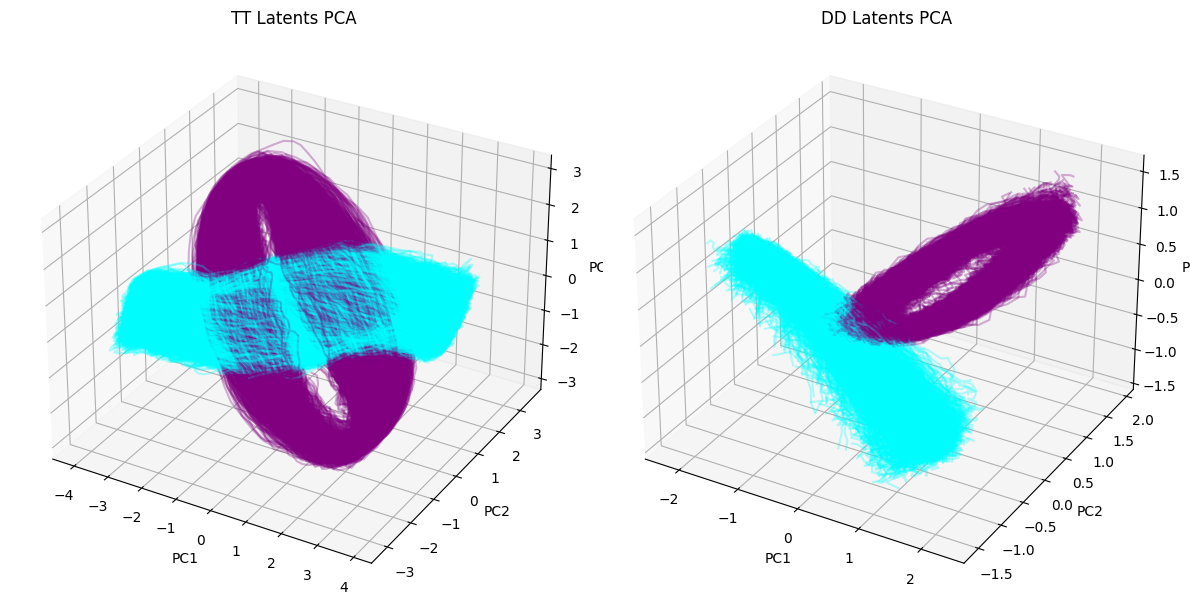

In [7]:
# Plot PCA

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
for i in range(lats_pca.shape[0]):
    ax.plot(lats_pca[i, extras[i,1].long():, 0], lats_pca[i, extras[i,1].long():, 1], lats_pca[i, extras[i,1].long():, 2], alpha=0.3, color='purple' if inds_stimA[i] else 'cyan' if inds_stimB[i] else 'k')
ax.set_title('TT Latents PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.grid()
ax = fig.add_subplot(122, projection='3d')
for i in range(lats_inf_pca.shape[0]):
    ax.plot(lats_inf_pca[i, extras[i,1].long():, 0], lats_inf_pca[i, extras[i,1].long():, 1], lats_inf_pca[i, extras[i,1].long():, 2], alpha=0.3, color='purple' if inds_stimA[i] else 'cyan' if inds_stimB[i] else 'k')
ax.set_title('DD Latents PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Save the figure as pdf
plt.tight_layout()
plt.savefig("pca_latents.pdf", format='pdf', bbox_inches='tight')


In [6]:
# get phase from inputs_nl[:,:,0]
def compute_theta(signal: np.ndarray) -> np.ndarray:
    """
    Compute instantaneous phase angle θ from a sinusoidal signal.

    Parameters
    ----------
    signal : np.ndarray, shape (B, T)
        Sinusoidal input in the range [-1, 1], where B is the number
        of trials and T the number of timepoints.

    Returns
    -------
    theta : np.ndarray, shape (B, T)
        Phase angles in radians, in [0, 2π).
    """
    # Estimate time‐derivative along axis=1
    ds = np.gradient(signal, axis=1)

    # Principal value of arcsin gives angles in [-π/2, π/2]
    principal = np.arcsin(signal)

    # Prepare output array
    theta = np.empty_like(principal)

    # Masks for each quadrant:
    #  Q1: sin≥0 & d(sin)/dt≥0
    q1 = (signal >= 0) & (ds >= 0)
    #  Q2: sin≥0 & d(sin)/dt<0
    q2 = (signal >= 0) & (ds <  0)
    #  Q3: sin<0  & d(sin)/dt<0
    q3 = (signal <  0) & (ds <  0)
    #  Q4: sin<0  & d(sin)/dt≥0
    q4 = (signal <  0) & (ds >= 0)

    # Assign phase in each quadrant
    theta[q1] = principal[q1]
    theta[q2] = np.pi - principal[q2]
    theta[q3] = np.pi - principal[q3]
    theta[q4] = 2 * np.pi + principal[q4]

    return theta
phases = inputs_nl[:,:,0]
theta = compute_theta(phases)
print(theta.shape)

(1000, 400)


In [7]:

flat_lats_trim_stimA = []
flat_lats_trim_stimB = []
flat_lats_trim_all = []
flat_lats_inf_trim_stimA = []
flat_lats_inf_trim_stimB = []
flat_lats_inf_trim_all = []
theta_trim_stimA = []
theta_trim_stimB = []
theta_trim_all = []
for i in range(lats.shape[0]):
    if inds_stimA[i]:
        flat_lats_trim_stimA.append(lats[i, extras[i,1].long():, :])
        flat_lats_inf_trim_stimA.append(lats_inf[i, extras[i,1].long():, :])
        theta_trim_stimA.append(theta[i, extras[i,1].long():])
    elif inds_stimB[i]:
        flat_lats_trim_stimB.append(lats[i, extras[i,1].long():, :])
        flat_lats_inf_trim_stimB.append(lats_inf[i, extras[i,1].long():, :])
        theta_trim_stimB.append(theta[i, extras[i,1].long():])
    
    flat_lats_trim_all.append(lats[i, extras[i,1].long():, :])
    flat_lats_inf_trim_all.append(lats_inf[i, extras[i,1].long():, :])
    theta_trim_all.append(theta[i, extras[i,1].long():])

flat_lats_trim_all = np.concatenate(flat_lats_trim_all, axis=0)
flat_lats_inf_trim_all = np.concatenate(flat_lats_inf_trim_all, axis=0)
theta_trim_all = np.concatenate(theta_trim_all, axis=0)

flat_lats_trim_stimA = np.concatenate(flat_lats_trim_stimA, axis=0)
flat_lats_inf_trim_stimA = np.concatenate(flat_lats_inf_trim_stimA, axis=0)
theta_trim_stimA = np.concatenate(theta_trim_stimA, axis=0)
flat_lats_trim_stimB = np.concatenate(flat_lats_trim_stimB, axis=0)
flat_lats_inf_trim_stimB = np.concatenate(flat_lats_inf_trim_stimB, axis=0)
theta_trim_stimB = np.concatenate(theta_trim_stimB, axis=0)

# Normalize the the flat lats by the mean and std of the latents
mean_lats_all_perNeuron = flat_lats_trim_all.mean(axis=0)
std_lats_all_perNeuron = flat_lats_trim_all.std(axis=0)

mean_lats_inf_all_perNeuron = flat_lats_inf_trim_all.mean(axis=0)
std_lats_inf_all_perNeuron = flat_lats_inf_trim_all.std(axis=0)

flat_lats_trim_stimA = (flat_lats_trim_stimA - mean_lats_all_perNeuron) / std_lats_all_perNeuron
flat_lats_inf_trim_stimA = (flat_lats_inf_trim_stimA - mean_lats_inf_all_perNeuron) / std_lats_inf_all_perNeuron

flat_lats_trim_stimB = (flat_lats_trim_stimB - mean_lats_all_perNeuron) / std_lats_all_perNeuron
flat_lats_inf_trim_stimB = (flat_lats_inf_trim_stimB - mean_lats_inf_all_perNeuron) / std_lats_inf_all_perNeuron


mean_lats_trim_stimA = flat_lats_trim_stimA.mean(axis=0)
mean_lats_inf_trim_stimA = flat_lats_inf_trim_stimA.mean(axis=0)
mean_lats_trim_stimB = flat_lats_trim_stimB.mean(axis=0)
mean_lats_inf_trim_stimB = flat_lats_inf_trim_stimB.mean(axis=0)

mean_dLats_stims = mean_lats_trim_stimA - mean_lats_trim_stimB
mean_dLats_inf_stims = mean_lats_inf_trim_stimA - mean_lats_inf_trim_stimB

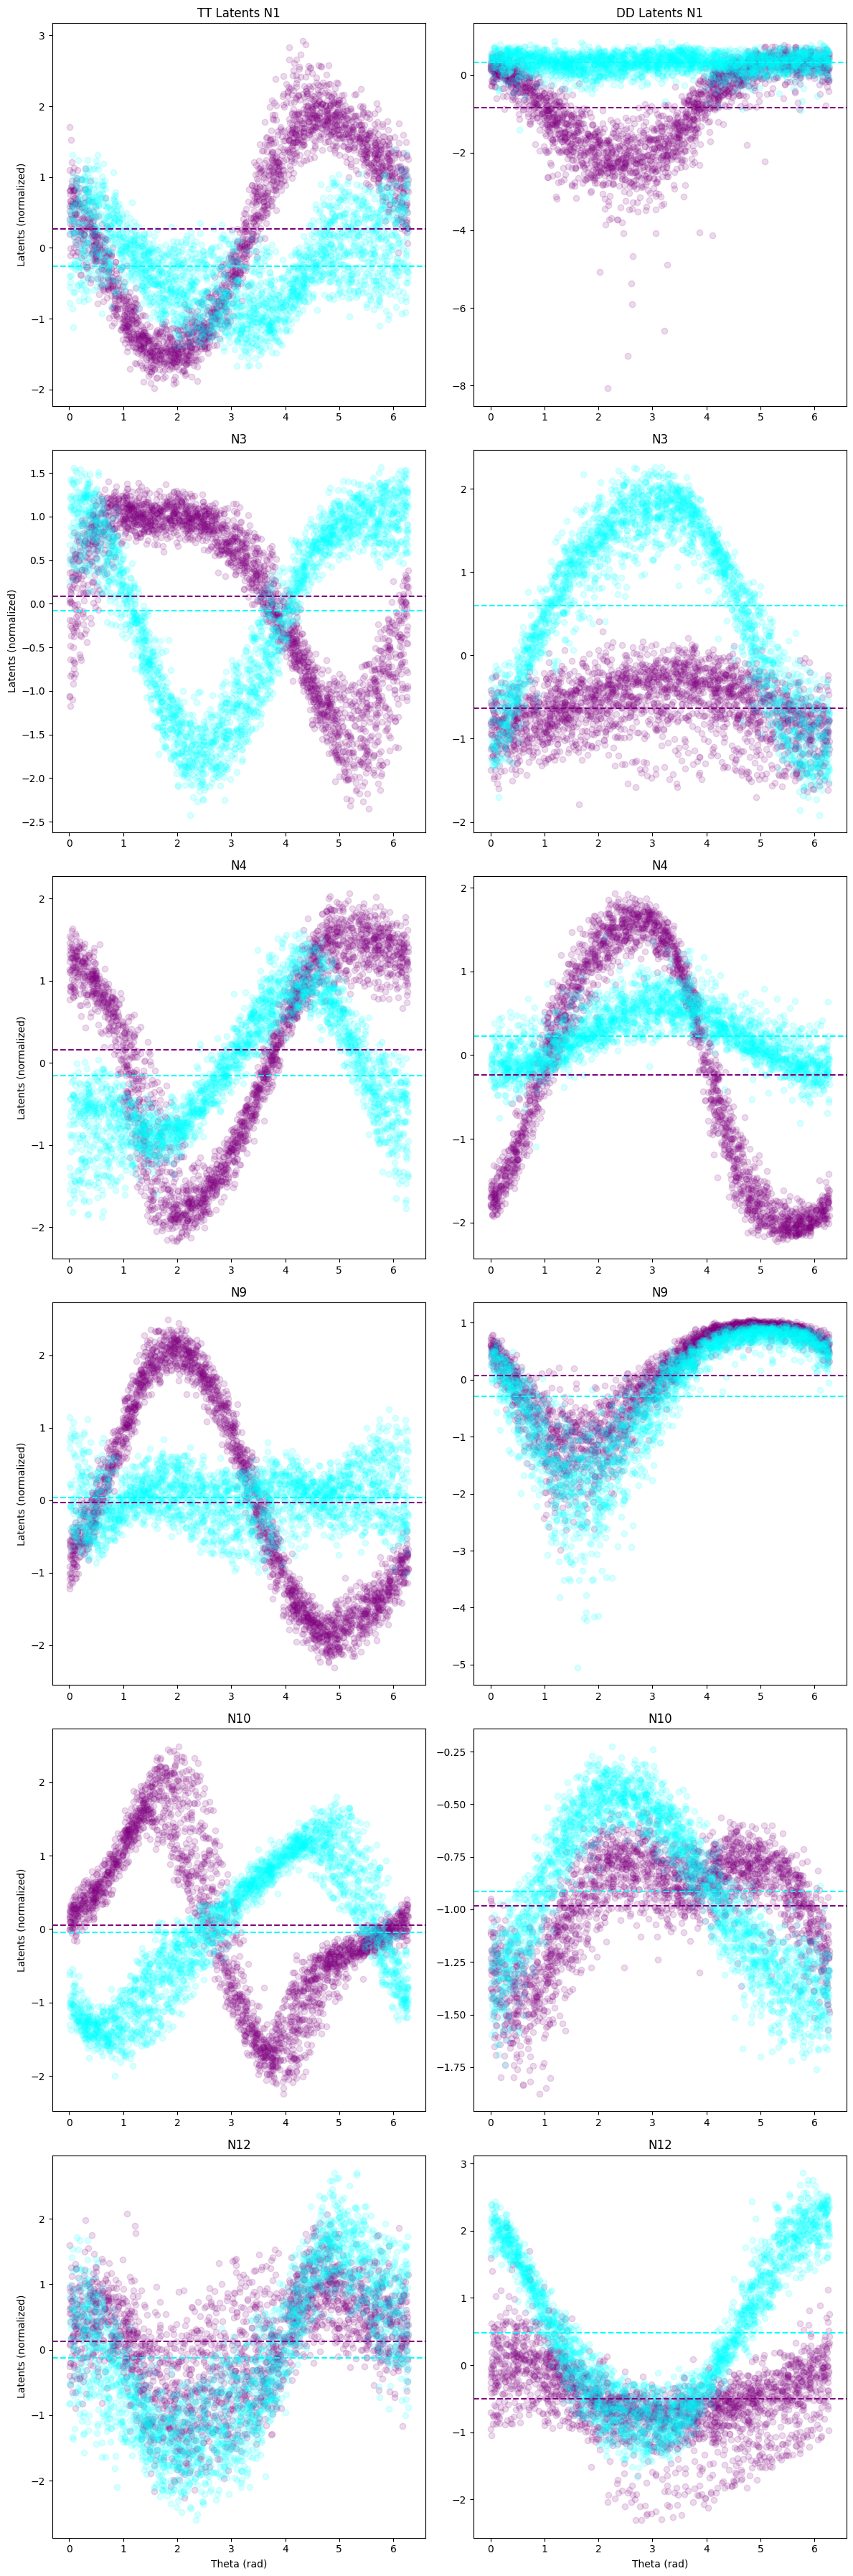

In [16]:
neuron_list = [1,3,4,9,10,12]
# Get index to downsample by 10x
downsample_idx = np.arange(0, flat_lats_trim_stimA.shape[0], 50)
fig=  plt.figure(figsize=(12, 6*len(neuron_list)))
for i, neuron_num in enumerate(neuron_list):
    ax = fig.add_subplot(len(neuron_list), 2, 2*i+1)
    ax.scatter(theta_trim_stimA[downsample_idx], flat_lats_trim_stimA[downsample_idx,neuron_num], color='purple', alpha=0.15)
    ax.scatter(theta_trim_stimB[downsample_idx], flat_lats_trim_stimB[downsample_idx,neuron_num], color='cyan', alpha=0.15)
    ax.axhline(mean_lats_trim_stimA[neuron_num], color='purple', linestyle='--')
    ax.axhline(mean_lats_trim_stimB[neuron_num], color='cyan', linestyle='--')
    ax.set_ylabel('Latents (normalized)')


    ax2 = fig.add_subplot(len(neuron_list), 2, 2*i+2)
    ax2.scatter(theta_trim_stimA[downsample_idx], flat_lats_inf_trim_stimA[downsample_idx,neuron_num], color='purple', alpha=0.15)
    ax2.scatter(theta_trim_stimB[downsample_idx], flat_lats_inf_trim_stimB[downsample_idx,neuron_num], color='cyan', alpha=0.15)
    ax2.axhline(mean_lats_inf_trim_stimA[neuron_num], color='purple', linestyle='--')
    ax2.axhline(mean_lats_inf_trim_stimB[neuron_num], color='cyan', linestyle='--')

    if i ==0:
        ax.set_title(f'TT Latents N{neuron_num}')
        ax2.set_title(f'DD Latents N{neuron_num}')
    else:
        ax.set_title(f'N{neuron_num}')
        ax2.set_title(f'N{neuron_num}')
    if i == len(neuron_list)-1:
        ax.set_xlabel('Theta (rad)')
        ax2.set_xlabel('Theta (rad)')

# Save the figure as pdf
plt.tight_layout()
plt.savefig("latents_vs_theta.pdf", format='pdf', bbox_inches='tight')


plt.show()



In [ ]:
neuron_list = [1,3,4,9,10,12]
# Get index to downsample by 10x
downsample_idx = np.arange(0, flat_lats_trim_stimA.shape[0], 50)
fig=  plt.figure(figsize=(12, 6*len(neuron_list)))
for i, neuron_num in enumerate(neuron_list):
    ax = fig.add_subplot(len(neuron_list), 2, 2*i+1)
    ax.scatter(theta_trim_stimA[downsample_idx], flat_lats_trim_stimA[downsample_idx,neuron_num], color='purple', alpha=0.15)
    ax.scatter(theta_trim_stimB[downsample_idx], flat_lats_trim_stimB[downsample_idx,neuron_num], color='cyan', alpha=0.15)
    ax.axhline(mean_lats_trim_stimA[neuron_num], color='purple', linestyle='--')
    ax.axhline(mean_lats_trim_stimB[neuron_num], color='cyan', linestyle='--')
    ax.set_ylabel('Latents (normalized)')


    ax2 = fig.add_subplot(len(neuron_list), 2, 2*i+2)
    ax2.scatter(theta_trim_stimA[downsample_idx], flat_lats_inf_trim_stimA[downsample_idx,neuron_num], color='purple', alpha=0.15)
    ax2.scatter(theta_trim_stimB[downsample_idx], flat_lats_inf_trim_stimB[downsample_idx,neuron_num], color='cyan', alpha=0.15)
    ax2.axhline(mean_lats_inf_trim_stimA[neuron_num], color='purple', linestyle='--')
    ax2.axhline(mean_lats_inf_trim_stimB[neuron_num], color='cyan', linestyle='--')

    if i ==0:
        ax.set_title(f'TT Latents N{neuron_num}')
        ax2.set_title(f'DD Latents N{neuron_num}')
    else:
        ax.set_title(f'N{neuron_num}')
        ax2.set_title(f'N{neuron_num}')
    if i == len(neuron_list)-1:
        ax.set_xlabel('Theta (rad)')
        ax2.set_xlabel('Theta (rad)')

# Save the figure as pdf
plt.tight_layout()
plt.savefig("latents_vs_theta.pdf", format='pdf', bbox_inches='tight')


plt.show()



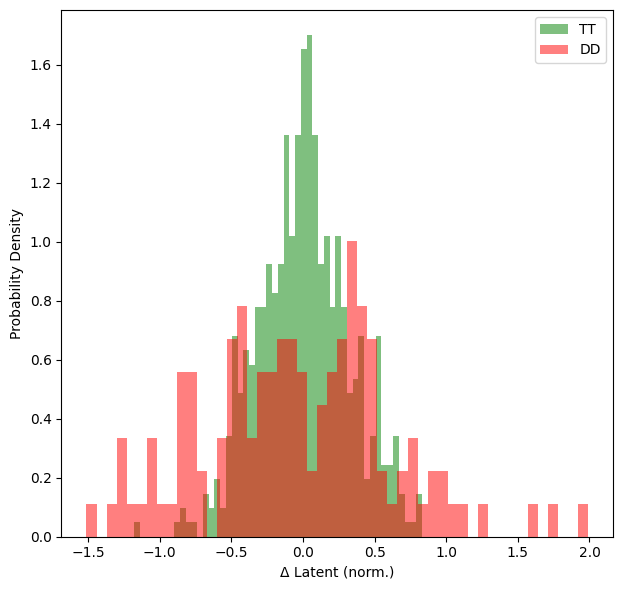

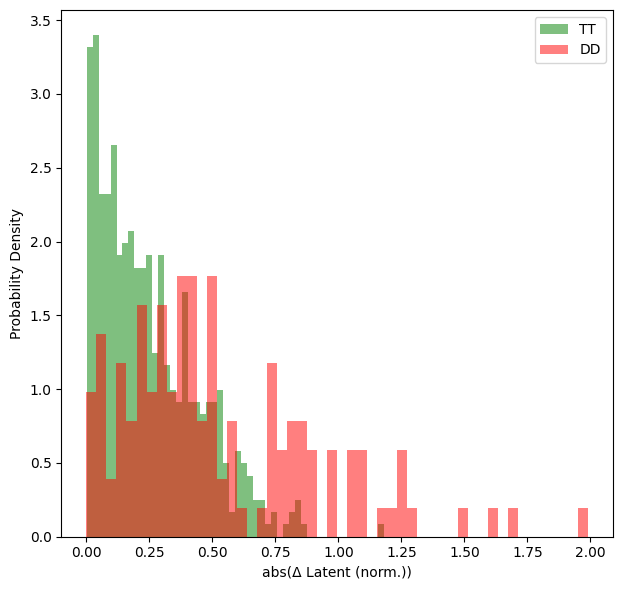

In [17]:

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)

# use density=True so each histogram is normalized
ax.hist(mean_dLats_stims,
        bins=50,
        density=True,
        color='green',
        alpha=0.5,
        label='TT')
ax.hist(mean_dLats_inf_stims,
        bins=50,
        density=True,
        color='red',
        alpha=0.5,
        label='DD')

ax.set_ylabel('Probability Density')
ax.set_xlabel('Δ Latent (norm.)')
ax.legend()
plt.tight_layout()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)

# use density=True so each histogram is normalized
ax.hist(np.abs(mean_dLats_stims),
        bins=50,
        density=True,
        color='green',
        alpha=0.5,
        label='TT')
ax.hist(np.abs(mean_dLats_inf_stims),
        bins=50,
        density=True,
        color='red',
        alpha=0.5,
        label='DD')

ax.set_ylabel('Probability Density')
ax.set_xlabel('abs(Δ Latent (norm.))')
ax.legend()
plt.tight_layout()
# Save the figure as pdf
plt.savefig("delta_latents_hist.pdf", format='pdf', bbox_inches='tight')
plt.show()